# **Diurnal cycle of precipitation**

In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, LocalCluster, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
from scipy import signal
from matplotlib import pyplot as plt # Standard Plotting library
from scipy import stats

**Define the nodes to use in this job**

In [3]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="128GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.115.233/368608/1' processes=1 threads=256, memory=119.21 GiB>

**dentifying files**

In [6]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0052_hourly_precipitation'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0052/precip/hourly')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0052 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [7]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0066_hourly_pr'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip/hourly')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [8]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_hourly_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/imerg')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**Setting functions**

In [9]:
def read_data(file,lon,lat,time,var):
    #if environ is 'trop':
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':24}),engine='netcdf4')
    pr=dset1[var].sel(lat=slice(lat[0],lat[1])).sel(lon=slice(lon[0],lon[1])).sel(time=slice(time[0],time[1])).chunk({'lon':360,'lat':200,'time':-1}).groupby('time.hour').mean()
    return pr*3600

In [10]:
def land_sea_mask(data,environ):
    if environ is 'trop':
        print('No computing of land_sea mask')
        pr = data
    else:
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=data.lon.values,lat=data.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        if environ is 'ocean':
            pr=data.where(lsmask01<0)
        elif environ is 'land':
            pr=data.where(lsmask01>0)
        else:
            return print('Wrong environ option')
    return pr

In [11]:
def create_local_hour(data):
    lhour1 = (data*0 + data.hour + 24/360*data.lon).round()
    lhour2 = lhour1.where(lhour1>=0,lhour1+24)
    lhour3 = lhour2.where(lhour2<24,lhour2-24)
    return lhour3

In [12]:
def daily_cycle(file,lon,lat,time,environ,var):
    data_new = read_data(file,lon,lat,time,var)
    #####calculate data_new
    dask_jobs = dask.persist(data_new)
    data_mod = dask.compute(data_new)

    data_mask = land_sea_mask(data_mod[0],environ)
    ####calculate local hour
    lhour = create_local_hour(data_mask)
    
    ####estimating diurnal cycle of precip
    dcycle = np.zeros((24,1))
    for t in range(24):
        dcycle[t,0] = data_mask.where(lhour==t).mean(skipna=True)
    return dcycle
    
    

**Ocean**

_24hr_

In [13]:
dcycle52_24hr_o = daily_cycle(file_dpp0052,[-180,180],[-30,30],['2020-02-01','2020-03-01'],'ocean','pr')

In [14]:
dcycle66_24hr_o = daily_cycle(file_dpp0066,[-180,180],[-30,30],['2020-02-01','2020-03-01'],'ocean','pr')

In [15]:
dcycleimerg_24hr_o = daily_cycle(file_imerg,[-180,180],[-30,30],['2020-02-01','2020-03-01'],'ocean','calibrated_precipitation')

**Land**

_24hr_

In [16]:
dcycle52_24hr_l = daiy_cycle(file_dpp0052,[-180,180],[-30,30],['2020-02-01','2020-03-01'],'land','pr')

In [17]:
dcycle66_24hr_l = daiy_cycle(file_dpp0066,[-180,180],[-30,30],['2020-02-01','2020-03-01'],'land','pr')

In [18]:
dcycleimerg_24hr_l = daiy_cycle(file_imerg,[-180,180],[-30,30],['2020-02-01','2020-03-01'],'land','calibrated_precipitation')

## Figure 1c,d

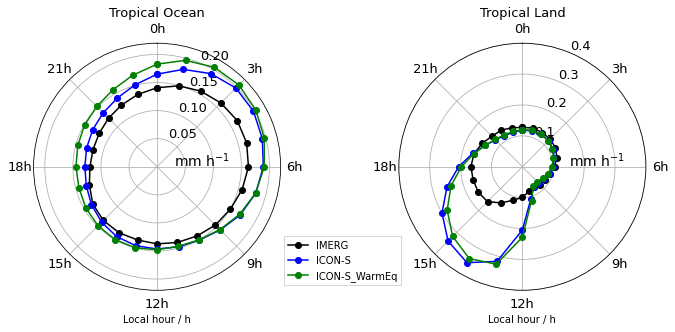

In [19]:
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(221, polar=True)
equals = np.linspace(0, 375, 25, endpoint=False) #np.arange(24)
ax.plot(np.deg2rad(equals),np.append(dcycleimerg_24hr_o,dcycleimerg_24hr_o[0])/3600,'-ok',label='IMERG')  
ax.plot(np.deg2rad(equals),np.append(dcycle66_24hr_o,dcycle66_24hr_o[0]),'-ob',label='ICON-S') 
ax.plot(np.deg2rad(equals),np.append(dcycle52_24hr_o,dcycle52_24hr_o[0]),'-og',label='ICON-S_WarmEq')  
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['0h','3h','6h','9h','12h','15h','18h','21h']); ax.set_xlabel('Local hour / h')
ax.set_theta_direction(-1)
ax.set_ylim([0,0.22]);ax.set_yticks(np.arange(0.05,0.21,0.05))
ax.set_theta_offset(np.pi/2.0) ; ax.tick_params(axis='both',labelsize=13)  
ax.set_title('Tropical Ocean',fontsize=13)
ax.legend(loc='lower center', bbox_to_anchor=(1.25, 0),
          ncol=1, fancybox=False, shadow=False)
plt.text((np.pi/2),0.03,'mm h$^{-1}$',fontsize=14)

ax = plt.subplot(222, polar=True)
equals = np.linspace(0, 375, 25, endpoint=False) #np.arange(24)
ax.plot(np.deg2rad(equals),np.append(dcycleimerg_24hr_l,dcycleimerg_24hr_l[0])/3600,'-ok')  
ax.plot(np.deg2rad(equals),np.append(dcycle66_24hr_l,dcycle66_24hr_l[0]),'-ob') 
ax.plot(np.deg2rad(equals),np.append(dcycle52_24hr_l,dcycle52_24hr_l[0]),'-og') 
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['0h','3h','6h','9h','12h','15h','18h','21h']); ax.set_xlabel('Local hour / h')
ax.set_theta_direction(-1)
ax.set_ylim([0,0.25]);ax.set_yticks(np.arange(0.1,0.41,0.1))
ax.set_theta_offset(np.pi/2.0); ax.tick_params(axis='both',labelsize=13)  
ax.set_title('Tropical Land',fontsize=13)
plt.text((np.pi/2),0.15,'mm h$^{-1}$',fontsize=14)
plt.savefig('/scratch/m/m300876/results/precip_paper/clock_diagram_diurnal_cycle_precip_feb_SRM_ICON_imerg_30N_30S_imerg_srmicon52_66.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

